In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

df = pd.read_csv('/content/drive/MyDrive/Fraud Analytics/Payments.csv')

# Encode nodes to integers
le = LabelEncoder()
le.fit(pd.concat([df['Sender'], df['Receiver']]))
df['sender_id'] = le.transform(df['Sender'])
df['receiver_id'] = le.transform(df['Receiver'])

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalization using Min-Max Scaler to [0, 1] range
scaler = MinMaxScaler()
df['Amount_normalized'] = scaler.fit_transform(df[['Amount']])

# Create edge index and edge weight tensors
edge_index = torch.tensor([df['sender_id'], df['receiver_id']], dtype=torch.long)
edge_weight = torch.tensor(df['Amount_normalized'], dtype=torch.float)

print(edge_index)
print(edge_weight)

# Number of nodes
num_nodes = len(le.classes_)
print(num_nodes)

# Create a PyG data object
graph_data = Data(edge_index=edge_index, num_nodes=num_nodes, edge_attr=edge_weight)

tensor([[290, 290, 290,  ..., 684, 684, 684],
        [ 10,  10,  10,  ..., 360, 360, 360]])
tensor([5.7254e-02, 5.5066e-02, 5.2263e-02,  ..., 1.7358e-03, 2.7320e-05,
        2.3363e-04])
799


In [ ]:
class EmbeddingGCN(torch.nn.Module):
    def __init__(self, num_features, embedding_dim):
        super(EmbeddingGCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, embedding_dim)

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

# Instantiate the model with embedding dimension, e.g., 2 for 2D visualization
model = EmbeddingGCN(num_features=1, embedding_dim=125)

# Initialize node features as ones
node_features = torch.ones((num_nodes, 1), dtype=torch.float)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop to learn embeddings
for epoch in range(300):  # More epochs for better convergence
    optimizer.zero_grad()
    embeddings = model(node_features, graph_data.edge_index, graph_data.edge_attr)
    loss = embeddings.norm(dim=1).mean()  # Dummy loss: Minimize the norm of embeddings
    loss.backward()
    optimizer.step()

    if epoch % 30 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item()}')

Epoch 0 | Loss: 2.156705617904663
Epoch 30 | Loss: 0.09719208627939224
Epoch 60 | Loss: 0.019384482875466347
Epoch 90 | Loss: 0.014689335599541664
Epoch 120 | Loss: 0.016454339027404785
Epoch 150 | Loss: 0.013610120862722397
Epoch 180 | Loss: 0.011644202284514904
Epoch 210 | Loss: 0.011698422022163868
Epoch 240 | Loss: 0.013524491339921951
Epoch 270 | Loss: 0.011217131279408932


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


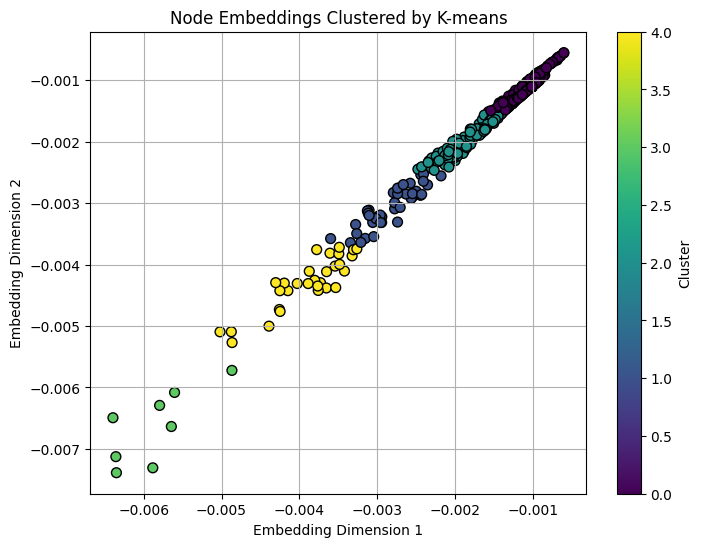

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize node features as ones
node_features = torch.ones((num_nodes, 1), dtype=torch.float)

embeddings = model(node_features, graph_data.edge_index, graph_data.edge_attr)

# Detach and convert embeddings to numpy for K-means
embeddings_np = embeddings.detach().numpy()

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_np)

# Cluster embeddings
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters
clusters = kmeans.fit_predict(embeddings_np)

# print("Cluster assignments:", clusters)

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1], c=clusters, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('Node Embeddings Clustered by K-means')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.grid(True)
plt.savefig('my_plot.png')
plt.show()